### Importing Librarires

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# Updating matplotlib parameters to match default LaTeX font
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

In [2]:
# Run in the system if never ran before
#pip install xgboost shap
#pip install pykalman

# Importing necessary libraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.inspection import permutation_importance
from pykalman import KalmanFilter
from scipy.stats import skew, kurtosis

### Importing Variables

In [3]:
# Importing results from XGB Model
result_weights_xgb = pd.read_csv("xgb_weights_output.csv", index_col=0, parse_dates=True)
result_te_xgb = pd.read_csv("xgb_te_output.csv", index_col=0, parse_dates=True)

# Importing results from Kalman Model
result_weights_kalman = pd.read_csv("kalman_weights_output.csv", index_col=0, parse_dates=True)
result_te_kalman = pd.read_csv("kalman_te_output.csv", index_col=0, parse_dates=True)

# Importing processed variables
processed_bonds_ret = pd.read_csv("processed_bond_returns.csv", index_col=0, parse_dates=True)
processed_index = pd.read_csv("processed_index_returns.csv", index_col=0, parse_dates=True)

In [4]:
# # Shifting the weights (signals) forward by one period
# weights_xgb_shifted = result_weights_xgb.shift(1).dropna()

# # Updating index returns to match the shifted weights dates
# updated_idx_ret = processed_index['Idx_Exc'].loc[weights_xgb_shifted.index].to_frame()

# # Updating Bond returns to match the shifted weights dataframe
# updated_bond_ret = processed_bonds_ret.loc[weights_xgb_shifted.index, weights_xgb_shifted.columns]

# # Calculating portfolio returns
# updated_port_ret = ((updated_bond_ret * weights_xgb_shifted).sum(axis=1)).to_frame()
# updated_port_ret.columns = updated_idx_ret.columns.to_list()

# # Calculating OOS tracking error
# updated_oos = np.sqrt((updated_idx_ret - updated_port_ret)**2)

# # Creating output variable
# updated_te_xgb = pd.DataFrame(index=result_te_xgb.index)
# first_colname = result_te_xgb.columns[0]
# updated_te_xgb[first_colname] = result_te_xgb[first_colname]
# updated_te_xgb = updated_te_xgb.join(updated_oos, how='left')
# updated_te_xgb.columns = result_te_xgb.columns.to_list()
# #updated_te_xgb

## Processing Results
- Lagging the signals being generated by one period, and calculating the out-of-sample returns.

In [5]:
# Defining a function to lag the weights (signals) by one period
def update_oos (bond_returns: pd.DataFrame,
               index_returns: pd.DataFrame,
               model_weights: pd.DataFrame,
               model_te: pd.DataFrame,
               shift_value: int=1):
    """
    A function that recalculates the OOS Tracking-Error for a given model. Outputs a dataframe with
    the same in-sample tracking errors, but updated out-of-sample (OOS) tracking errors.
    """
    # Shifting the weights (signals) by the shift value
    weights_shifted = model_weights.shift(shift_value).dropna()

    # Updating Index returns to match shifted weights
    index_shifted = index_returns['Idx_Exc'].loc[weights_shifted.index].to_frame()

    # Updating Bond returns to match the shifted weights
    bonds_shifted = bond_returns.loc[weights_shifted.index, weights_shifted.columns]
    
    # Calculating Updated portfolio returns
    updated_port_ret = ((bonds_shifted * weights_shifted).sum(axis=1)).to_frame()
    updated_port_ret.columns = index_shifted.columns.to_list()

    # Calculating OOS Tracking Error
    updated_oos = np.sqrt(((index_shifted - updated_port_ret)**2))

    # Creating output variable
    output_te = pd.DataFrame(index=model_te.index)
    first_colname = model_te.columns[0]
    output_te[first_colname] = model_te[first_colname]

    # Appending the updated OOS to this output variable
    output_te = output_te.join(updated_oos, how='left')
    output_te.columns = model_te.columns.to_list()

    # Returning the output variable
    return {
        'weights_shifted': weights_shifted,
        'updated_te': output_te
    }

In [6]:
# Running the shifted calculations for XGB
shifted_xgb = update_oos(
    bond_returns = processed_bonds_ret,
    index_returns = processed_index,
    model_weights = result_weights_xgb,
    model_te = result_te_xgb
)
shifted_weights_xgb = shifted_xgb['weights_shifted']
shifted_te_xgb = shifted_xgb['updated_te']

# Running the shifted calculations for Kalman
shifted_kalman = update_oos(
    bond_returns = processed_bonds_ret,
    index_returns = processed_index,
    model_weights = result_weights_kalman,
    model_te = result_te_kalman
)
shifted_weights_kalman = shifted_kalman['weights_shifted']
shifted_te_kalman = shifted_kalman['updated_te']

## Post-Implementation Analysis

### Tracking Error Evaluation

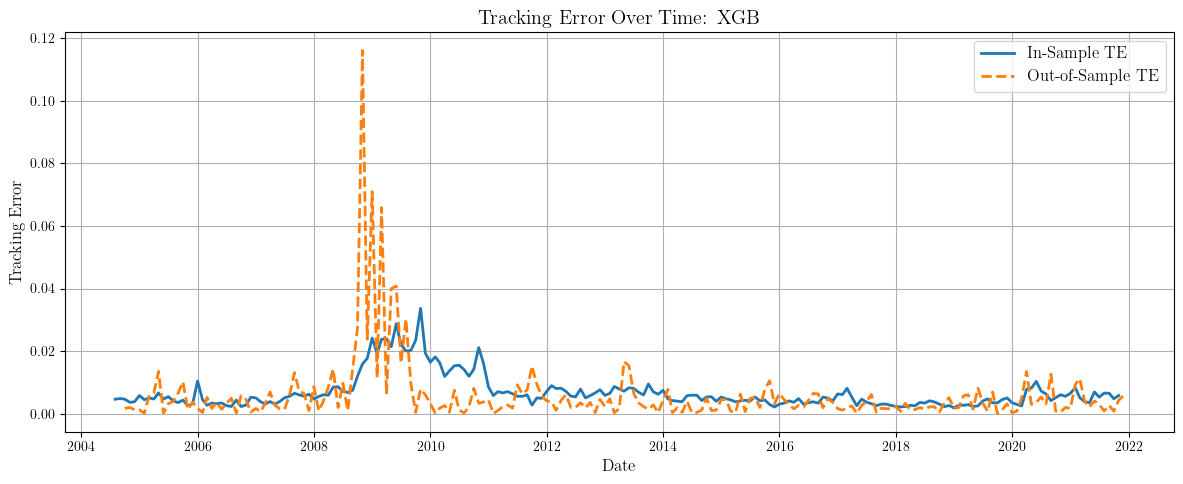

In [7]:
# Plotting Tracking Errors
def plot_tracking_errors(te_df, model_str):
    plt.figure(figsize=(12, 5))
    plt.plot(te_df.index, te_df[f'INS_TE_{model_str}'], label='In-Sample TE', linewidth=2)
    plt.plot(te_df.index, te_df[f'OOS_TE_{model_str}'], label='Out-of-Sample TE', linewidth=2, linestyle='--')
    plt.title(f'Tracking Error Over Time: {model_str}')
    plt.xlabel('Date')
    plt.ylabel('Tracking Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Plots/te_overtime_{model_str}.png", dpi=300, bbox_inches='tight')
    plt.show()
# Plotting tracking errors for XGB
plot_tracking_errors(shifted_te_xgb, 'XGB')

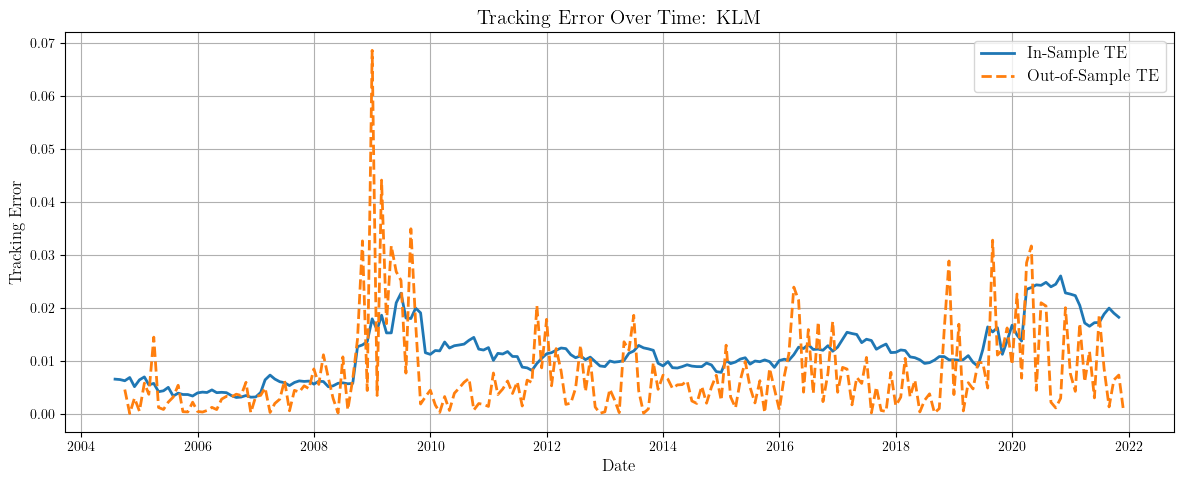

In [8]:
# Plotting tracking errors for Kalman
plot_tracking_errors(shifted_te_kalman, 'KLM')

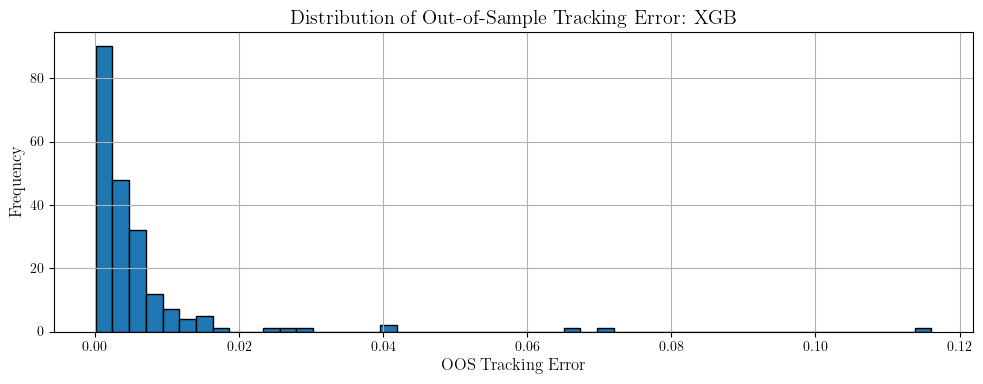

In [9]:
def plot_te_distribution(te_df, model_str):
    plt.figure(figsize=(10,4))
    plt.hist(te_df[f'OOS_TE_{model_str}'].dropna().astype(float), bins=50, edgecolor='black')
    plt.title(f'Distribution of Out-of-Sample Tracking Error: {model_str}')
    plt.xlabel('OOS Tracking Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(f"Plots/te_dist_{model_str}.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    
    plt.show()
plot_te_distribution(shifted_te_xgb, 'XGB')

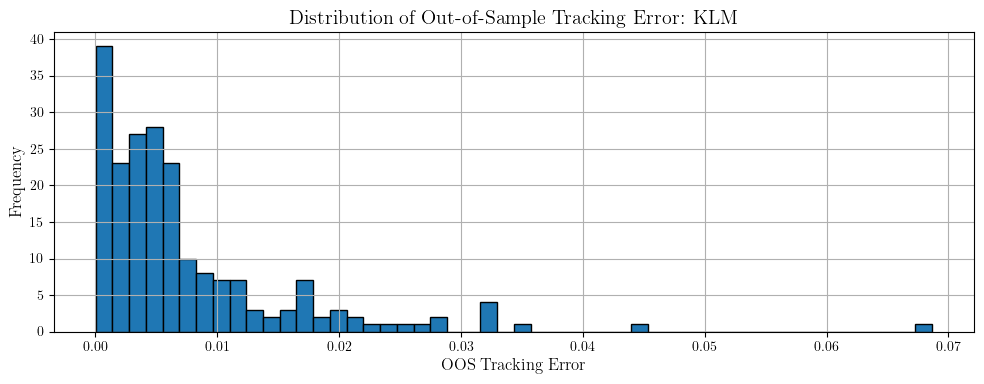

In [10]:
plot_te_distribution(shifted_te_kalman, 'KLM')

In [11]:
def compare_sample_perf(model1_te: pd.DataFrame,
                         model1_str: str,
                         model2_te: pd.DataFrame,
                         model2_str: str,
                         te_str: str):
    
    # Setting variable name
    sample_name = 'In-Sample' if te_str == 'INS' else 'Out-of-Sample'

    # Plotting the figure
    plt.figure(figsize=(12, 5))

    # Different plot types based on return type
    if te_str == 'INS':
        
        plt.plot(model1_te.index, model1_te[f'{te_str}_TE_{model1_str}'],
                 label=f'{model1_str} TE', linewidth=2, color='#2ca02c')
        plt.plot(model2_te.index, model2_te[f'{te_str}_TE_{model2_str}'],
                 label=f'{model2_str} TE', linewidth=2, color='#9467bd')
    else:
        plt.plot(model1_te.index, model1_te[f'{te_str}_TE_{model1_str}'],
                 label=f'{model1_str} TE', linewidth=2, color='#2ca02c', linestyle='--')
        plt.plot(model2_te.index, model2_te[f'{te_str}_TE_{model2_str}'],
                 label=f'{model2_str} TE', linewidth=2, color='#9467bd', linestyle='--')

    plt.title(f'Comparing {sample_name} Tracking Error between {model1_str} and {model2_str}')
    plt.xlabel('Date')
    plt.ylabel('Tracking Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Plots/KLM_vs_XGB_{te_str}.png", dpi=300, bbox_inches='tight')
    plt.show()

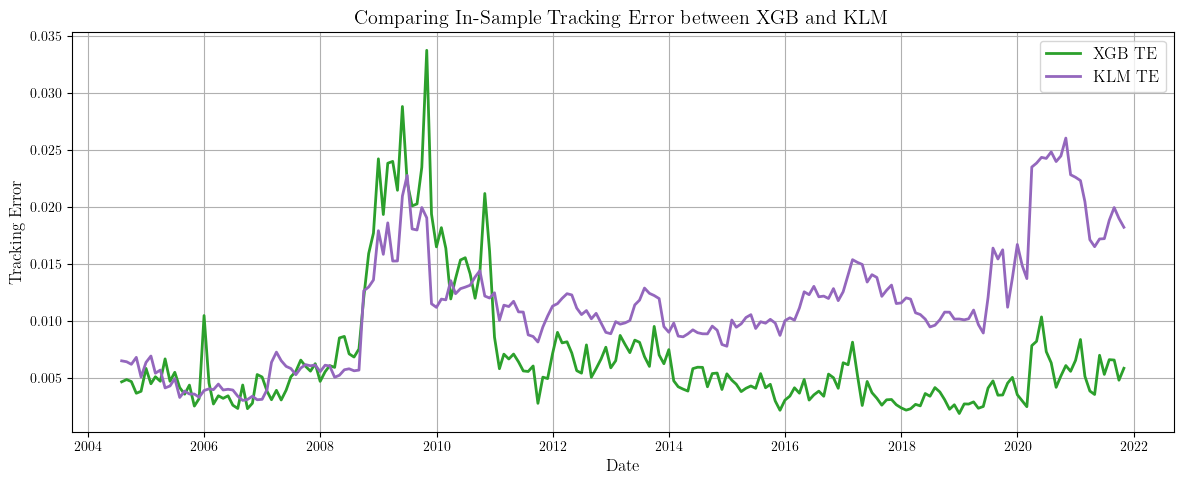

In [12]:
compare_sample_perf(
    shifted_te_xgb,
    'XGB',
    shifted_te_kalman,
    'KLM',
    'INS'
)

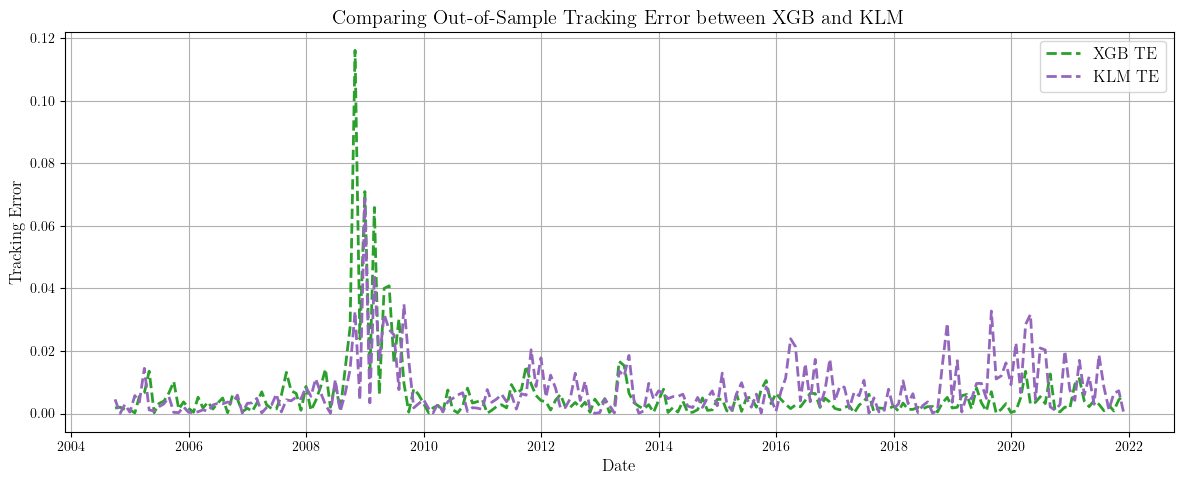

In [13]:
compare_sample_perf(
    shifted_te_xgb,
    'XGB',
    shifted_te_kalman,
    'KLM',
    'OOS'
)

In [73]:
def summarize_te(te_df):
    # Creating summary df in raw form
    interim_df = te_df.astype(float).describe().T
    
    colnames = interim_df.columns.to_list()
    first_col = colnames.pop(0)

    # Creating resulting dataframe
    result_df = pd.DataFrame(index = interim_df.index)
    result_df[first_col] = interim_df[first_col]

    # Annualizing values, and converting into %
    interim_df *= 100
    #interim_df *= np.sqrt(12)
    
    for name in colnames:
        result_df[name] = interim_df[name]
    
    return result_df
    
summarize_te(shifted_te_xgb)

,count,mean,std,min,25%,50%,75%,max
INS_TE_XGB,208.0,0.685768,0.532773,0.193383,0.380391,0.524464,0.715933,3.372247
OOS_TE_XGB,207.0,0.584639,1.143899,0.013790,0.152360,0.320334,0.611501,11.609745


In [74]:
summarize_te(shifted_te_kalman)

,count,mean,std,min,25%,50%,75%,max
INS_TE_KLM,208.0,1.115445,0.505878,0.308066,0.813805,1.064849,1.302206,2.604139
OOS_TE_KLM,207.0,0.749425,0.880769,0.005257,0.211912,0.480176,0.872144,6.866129


### Bonds Portfolio Evaluation

In [16]:
# Counting how many bonds were held
def count_bonds_held(weights_df):
    held_counts = (weights_df != 0.0).sum(axis=1)
    held_counts.name = "Num_Bonds_Held"
    return held_counts
    
# Plotting these bonds
def plot_bonds_held(bonds_held_series, model_str):
    plt.figure(figsize=(12, 4))
    plt.plot(bonds_held_series.index, bonds_held_series.values, marker='o')
    plt.title(f"Number of Bonds Held Over Time: {model_str}")
    plt.xlabel("Date")
    plt.ylabel("Number of Bonds")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Plots/bonds_held_{model_str}.png", dpi=300, bbox_inches='tight')
    plt.show()

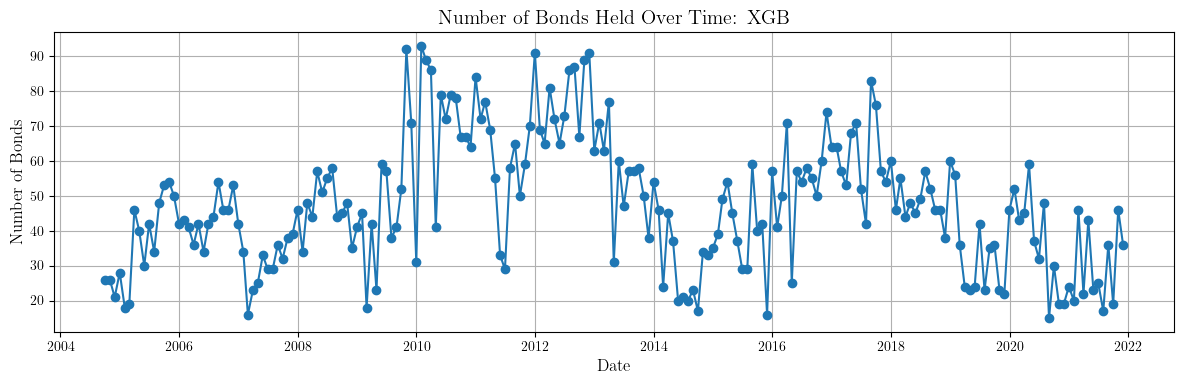

In [17]:
count_bonds_xgb = count_bonds_held(shifted_weights_xgb)
plot_bonds_held(count_bonds_xgb, 'XGB')

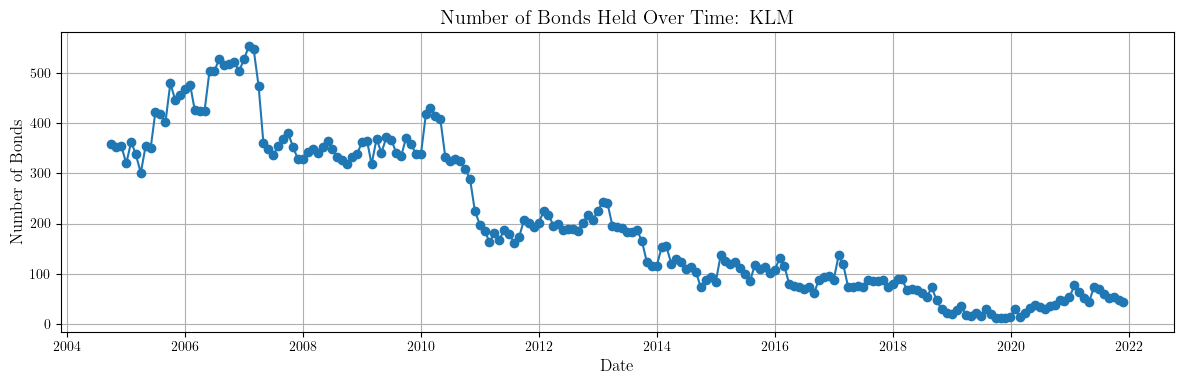

In [18]:
count_bonds_kalman = count_bonds_held(shifted_weights_kalman)
plot_bonds_held(count_bonds_kalman, 'KLM')

In [19]:
processed_index

,Idx_Price,Idx_Returns,Idx_Exc,Idx_MCap,Idx_Count
Date,,,,,
2002-08-31,1257.87,0.026523,0.025106,1666173.29,3580
2002-09-30,1281.86,0.019072,0.017739,1701668.57,3586
2002-10-31,1264.65,-0.013426,-0.014659,1673274.91,3574
2002-11-30,1284.43,0.015641,0.014599,1685374.02,3535
2002-12-31,1323.64,0.030527,0.029527,1736694.47,3530
...,...,...,...,...,...
2021-07-31,3563.68,0.013688,0.013646,6962832.37,6838
2021-08-31,3552.90,-0.003025,-0.003050,6957292.32,6902
2021-09-30,3515.50,-0.010527,-0.010585,6876915.12,6938


### Correlation Analysis

In [45]:
# Slicing bond returns to calculate portfolio returns overtime
def plot_port_performance(result_weights,
                         processed_bonds,
                         processed_index,
                          model_str,
                         transaction_costs: float=0.001):
    '''
    A function that calculates the portfolio return from the output weights DataFrame,
    calculates the correlation between the portfolio and the index, and also plots these
    returns for comparision
    '''
    # Creating necessary variables
    sliced_bonds = processed_bonds.loc[result_weights.index, result_weights.columns]
    sliced_index = processed_index['Idx_Exc'].loc[result_weights.index].to_frame()
    port_ret_gross = ((sliced_bonds * result_weights).sum(axis=1)).to_frame()
    port_ret_gross.columns = ['OOS_Port_Ret']

    # Including transaction costs
    weights = result_weights.copy()
    turnover = (weights - weights.shift(1)).abs()
    monthly_turnover = turnover.sum(axis=1).to_frame()
    # Fix: Create a DataFrame first, then rename the column
    port_ret_net = (port_ret_gross.iloc[:, 0] - (monthly_turnover.iloc[:, 0] * transaction_costs)).to_frame()
    port_ret_net.columns = ['OOS_Port_Ret_Net']

    # Calculating correlations
    comparison_df = pd.concat([port_ret_net, sliced_index], axis=1)
    correlation = comparison_df.corr().iloc[0,1]
    
    # Plotting the cumulative returns
    comparison_df.cumsum().plot(figsize=(10,5), title=f'OOS Cumulative Returns\nCorrelation = {correlation:.3f}\nModel: {model_str}')
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.savefig(f"Plots/correlation_analysis_{model_str}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Return variables
    return (comparison_df * 100)

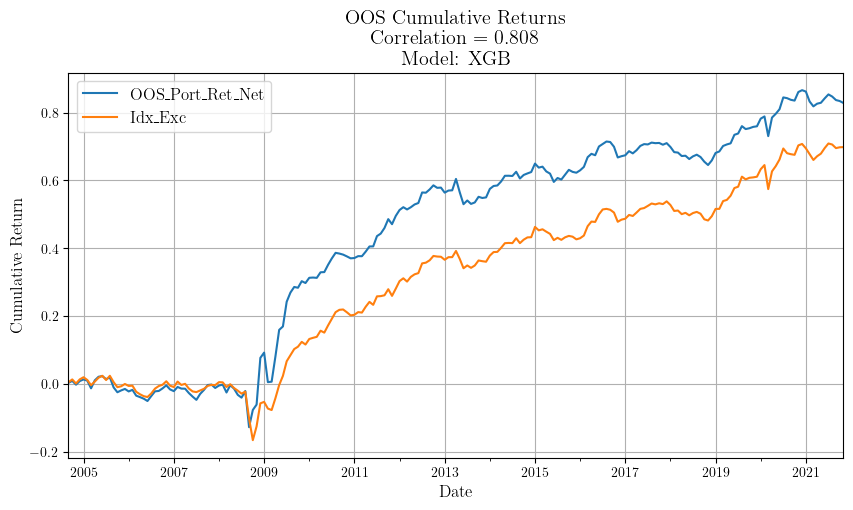

In [46]:
# Plotting the results 
xgb_ret_perf = plot_port_performance(shifted_weights_xgb,
                     processed_bonds_ret,
                     processed_index,
                     model_str = 'XGB',
                     transaction_costs=0.001)

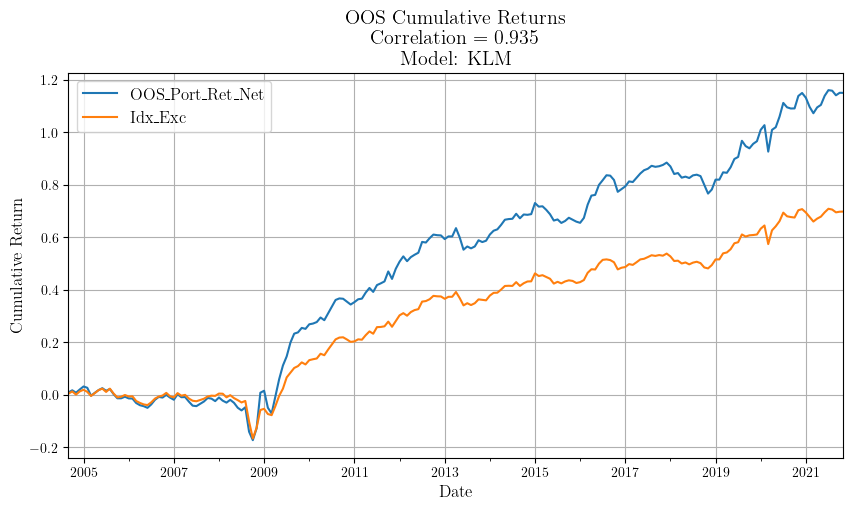

In [47]:
# Plotting the results 
klm_ret_perf = plot_port_performance(shifted_weights_kalman,
                     processed_bonds_ret,
                     processed_index,
                     model_str = 'KLM',
                     transaction_costs=0.001)

In [69]:
def stat_measures(returns_df):
    '''
    Calculates mean, standard deviation, skewness, kurtosis, correlation, sharpe ratio for a
    given set of model and index returns.
    '''
    # Creating final dataframe
    result_df = pd.DataFrame(index=returns_df.columns)

    # Calculating values (annualizing everything)
    result_df['Mean'] = returns_df.mean() * 12
    result_df['Std_Dev'] = returns_df.std() * np.sqrt(12)
    result_df['Skewness'] = returns_df.apply(skew)
    result_df['Kurtosis'] = returns_df.apply(lambda x: kurtosis(x, fisher=False))
    result_df['Correlation'] = [returns_df.corr().iloc[0,1] , returns_df.corr().iloc[0,0]]
    result_df['Sharpe Ratio'] = returns_df.mean() / returns_df.std()

    # Returning final dataframe
    return result_df

In [71]:
xgb_measures = stat_measures(xgb_ret_perf)
xgb_measures

,Mean,Std_Dev,Skewness,Kurtosis,Correlation,Sharpe Ratio
OOS_Port_Ret_Net,4.802399,7.492927,0.555563,14.790131,0.808163,0.185019
Idx_Exc,4.049121,5.740648,-0.766139,8.904364,1.000000,0.203615


In [72]:
klm_measures = stat_measures(klm_ret_perf)
klm_measures

,Mean,Std_Dev,Skewness,Kurtosis,Correlation,Sharpe Ratio
OOS_Port_Ret_Net,6.669926,8.694080,0.247567,8.432283,0.935361,0.221466
Idx_Exc,4.049121,5.740648,-0.766139,8.904364,1.000000,0.203615


### Lead-Lag Analysis

In [23]:
# Conducting a lead-lag analysis on the correlation with index.
def lead_lag (bond_returns: pd.DataFrame,
             index_returns: pd.DataFrame,
             model_weights: pd.DataFrame,
             shift_value: int=12):
    '''
    A function that conducts lead-lag analysis on the weights generated by models. Computes the
    correlation of portfolio returns and index returns for each shifted value.
    '''
    # Creating variable lists
    lead_lag_list = []
    correl_values = []
    oos_te_values = []

    # Running the main loop 
    for lag in range(-shift_value, shift_value+1):
        
        # Creatin lagged weights
        lagged_weights = model_weights.shift(lag).dropna(inplace=False)
        sliced_returns = bond_returns.loc[lagged_weights.index, lagged_weights.columns]
        sliced_index = index_returns['Idx_Exc'].loc[lagged_weights.index].to_frame()

        # Calculating Portfolio Returns
        port_ret = (lagged_weights * sliced_returns).sum(axis=1).to_frame()
        port_ret.columns = ['Port_Ret']

        # Calculating correlation
        comparision_df = pd.concat([sliced_index, port_ret], axis=1)
        correl = comparision_df.corr().iloc[0,1]

        # Calculating tracking error
        port_ret.columns = sliced_index.columns.to_list()
        oos_te = (np.sqrt((sliced_index - port_ret)**2)).mean().values[0]
        oos_te = np.sqrt(((sliced_index - port_ret)**2).mean()).values[0]

        # Appending values to the list
        lead_lag_list.append(lag)
        correl_values.append(correl)
        oos_te_values.append(oos_te)

    # Returning a dataframe with all variables
    output_df = pd.DataFrame({
        'Lag_Value': lead_lag_list,
        'Correlation': correl_values,
        'OOS_TE': oos_te_values
    })
    output_df = output_df.set_index('Lag_Value')
    
    return output_df

In [24]:
# Running Lead-Lag for XGB
lead_lag_xgb = lead_lag(
    bond_returns = processed_bonds_ret,
    index_returns = processed_index,
    model_weights = result_weights_xgb
)

# Running Lead-Lag for Kalman
lead_lag_kalman = lead_lag(
    bond_returns = processed_bonds_ret,
    index_returns = processed_index,
    model_weights = result_weights_kalman
)

In [25]:
# Creating a function to plot results from lead-lag analysis
def plot_lead_lag(output_df: pd.DataFrame,
                  model_str: str,
                  save: bool = False):
    '''
    Plots the correlation and tracking error from the lead-lag output.
    Highlights lag=0 bar, adds annotations, spacing, and adjustable layout.
    '''

    # Parameters
    bar_width = 0.5   # < 1 to add space between bars
    annotation_fontsize = 6
    buffer_ratio = 1.10  # Adds 10% space above highest bar

    # Color scheme: red for lag=0
    bar_colors = ['tab:blue' if lag != 0 else 'tab:red' for lag in output_df.index]

    # --- Correlation Plot ---
    fig_corr, ax_corr = plt.subplots(figsize=(12, 4))
    bars_corr = ax_corr.bar(output_df.index, output_df['Correlation'],
                            color=bar_colors, width=bar_width)
    
    # Set y-limits to avoid annotation clash
    max_corr = output_df['Correlation'].max()
    ax_corr.set_ylim(top=max_corr * buffer_ratio)

    # Labels, grid, etc.
    ax_corr.axhline(0, color='black', linestyle='--', linewidth=1)
    ax_corr.set_title(f"Correlation vs Lag \n Model: {model_str}")
    ax_corr.set_xlabel("Lag (months)")
    ax_corr.set_ylabel("Correlation")
    #ax_corr.grid(True, linestyle='--', alpha=0.5)

    # Annotate bars
    for bar in bars_corr:
        height = bar.get_height()
        ax_corr.annotate(f'{height:.4f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom',
                         fontsize=annotation_fontsize)

    if save:
        fig_corr.savefig(f"Plots/leadlag_correl_{model_str}.png", bbox_inches='tight', dpi=300)

    # --- Tracking Error Plot ---
    fig_te, ax_te = plt.subplots(figsize=(12, 4))
    bars_te = ax_te.bar(output_df.index, output_df['OOS_TE'],
                        color=bar_colors, width=bar_width)

    max_te = output_df['OOS_TE'].max()
    ax_te.set_ylim(top=max_te * buffer_ratio)

    ax_te.set_title(f"Tracking Error vs Lag \n Model: {model_str}")
    ax_te.set_xlabel("Lag (months)")
    ax_te.set_ylabel("Tracking Error")
    #ax_te.grid(True, linestyle='--', alpha=0.5)

    for bar in bars_te:
        height = bar.get_height()
        ax_te.annotate(f'{height:.4f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=annotation_fontsize)

    if save:
        fig_te.savefig(f"Plots/leadlag_te_{model_str}.png", bbox_inches='tight', dpi=300)

    plt.show()

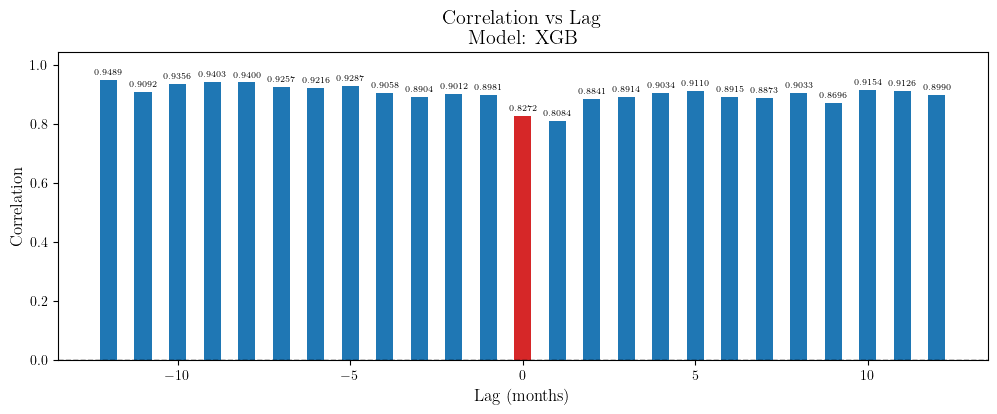

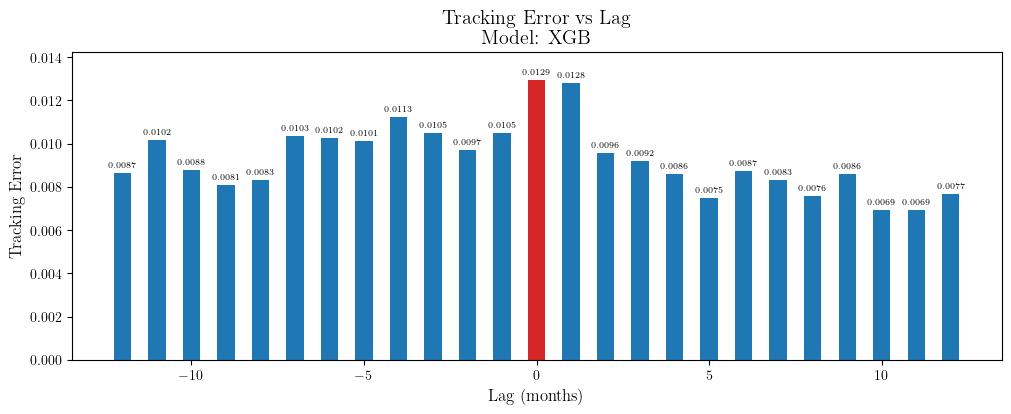

In [26]:
plot_lead_lag(lead_lag_xgb, model_str ='XGB', save=True)

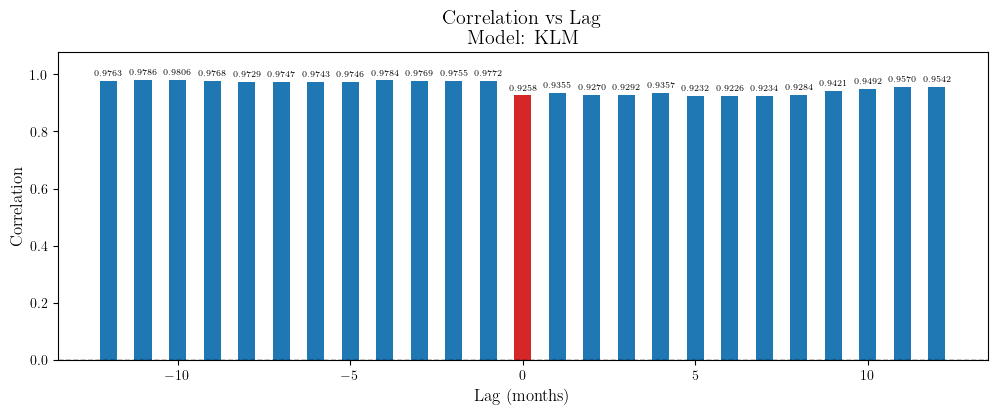

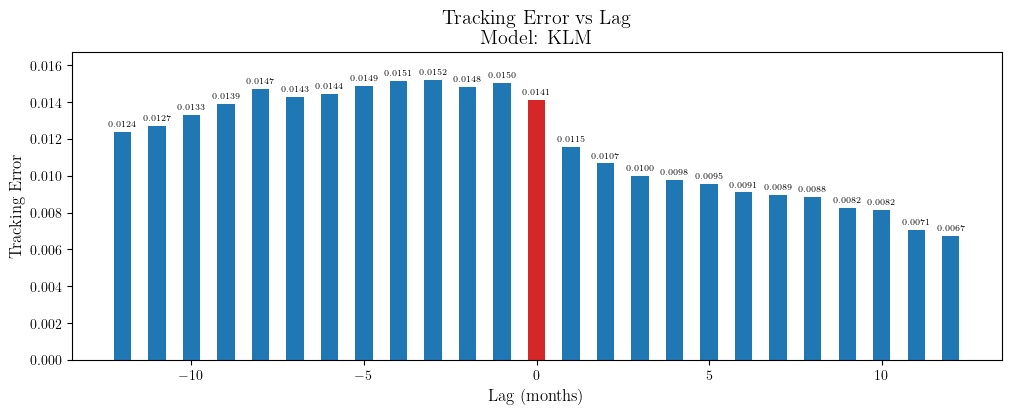

In [27]:
plot_lead_lag(lead_lag_kalman, model_str = 'KLM', save=True)